# <font color="brown">🎓&nbsp;&nbsp; Introduction</font>

In this exercice, you will discover an interesting way to use genetic algorithm: image recreation.

This is inspired by the Genetic Programming implementation of this by Roger Johansson (https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/) and the countless Genetic Algorithm implementations that followed.

## <font color="brown">🏕&nbsp;&nbsp; Environment</font>
This notebook has been tested on Google Colab but you can run it elsewhere. Just make sure to put the image you want to recreate either on Google Drive or on your disk depending on the platform of your choice.

## <font color="brown">🏗&nbsp;&nbsp; Load image and libraries</font>

In [131]:
# from google.colab import drive
# drive.mount('/content/drive')

In [132]:
# %pip install pygad

In [174]:
import cv2
import numpy as np

original_image = cv2.imread('./img/chien.jpg') # Load image (change this path if needed)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) # Convert image from BGR format to RGB
original_image = cv2.resize(original_image, (original_image.shape[1] // 4, original_image.shape[0] // 4)) # Resize image
original_image = np.float32(original_image) / 255 # Rescale image to [0, 1]

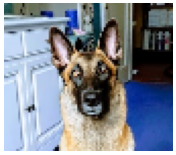

In [175]:
import matplotlib.pyplot as plt
from skimage import filters

plt.figure(dpi=40) # Change the resolution at which we plot the image
plt.imshow(original_image)
plt.axis('off'); # Do not plot axes for this figure

## <font color="brown">✍️&nbsp;&nbsp; Configure some parameters</font>

Note that the parameters values here have been chosen based on some experiments on our part.

In [176]:
import pygad
import numpy as np

# RGB mean and std taken from the original image
# RGB_MEAN, RGB_STD = np.mean(original_image, axis=(0, 1)), np.std(original_image, axis=(0, 1))

pixel_values = original_image.reshape(-1, 3)
PALETTE = np.unique(pixel_values, axis=0) # Get unique colors in the image
random_palette_idx = np.random.choice(len(PALETTE), 32, replace=False) # Choose 32 random colors from the palette
PALETTE = PALETTE[random_palette_idx]

# Image's width and height
IMG_HEIGHT, IMG_WIDTH = original_image.shape[:2]

# Properties of ellipse: RGB + (X,Y) + (width, height) + angle
N_PROPERTIES = 3 + 2 + 2 + 1

# Number of shapes for each paintings "layers"
N_SHAPES_LIST = [120, 60, 20]

# Number of populations individuals for each paintings "layers"
N_INDIVIDUAL_LIST = [250, 500, 500]

# The transparency at which we paint the shapes on top of each other for each painting layers
TRANSPARENCY_LIST = [1, 1, 1] # Instead of getting rid of transparency entierely, we simply set shapes to be opaque

# The number of painting layers
N_STEP = len(N_SHAPES_LIST)

## <font color="brown">🔧&nbsp;&nbsp; Define utils functions</font>

### <font color="brown">Chromosome Encoding</font>
Our chromosome is encoded as follow:

\[Red, Green, Blue, X1, Y1, X2, Y2, X3, Y3, X4, Y4\], where X _i_ and Y _i_ are the coordinates of the corner _i_ of the shape.

### <font color="brown">Initial Population</font>
We generate a value between 0 and 1 regardless of the gene, be it a color or a coordinate. It makes it easier for the evolution to have all the genes with the same scale. We will recover the right scale when drawing the image corresponding to a chromosome.

We've computed the mean and standard deviation of the red, blue and green values of the image we aim to recreate. We will generate a first population by sampling color distributed on a normal with those mean and standard deviation to help a bit finding colors close to the images ones.

In [177]:
def generate_random_chromosomes(n_shapes):
  chromosomes = np.empty((n_shapes * N_PROPERTIES))

  for shape_idx in range(0, n_shapes * N_PROPERTIES, N_PROPERTIES):
      # Generate chromosome color values
      # chromosomes[shape_idx : (shape_idx + 3)] = np.random.normal(RGB_MEAN, RGB_STD, size=3)
      chromosomes[shape_idx : (shape_idx + 3)] = PALETTE[np.random.randint(0, len(PALETTE))]
      
      # Generate chromosome coordinates and size values
      chromosomes[(shape_idx + 3) : (shape_idx + 7)] = np.random.uniform(0, 1, size=4)  # X1, Y1, Width, Height
            
      # Generate chromosome angle values
      chromosomes[(shape_idx + 7)] = np.random.uniform(0, 1)
      
  return np.clip(chromosomes, 0, 1) # Ensure all values are constrained between 0 and 1

### <font color="brown">Define callbacks</font>

This callback will be called at each generation. We make a closure function to define a callback that takes a canvas (the background) and a transparency parameter (the transparency at which to draw polygons)


In [178]:
# Define a closure function on_gen that takes canvas and transparency as arguments
def on_gen(canvas, transparency):

    # Define a nested function on_generation that takes the genetic algorithm instance as argument
    def on_generation(ga_instance):

        # Display the solution fitness and painting each 10 generations
        if (ga_instance.generations_completed - 1) % 10 == 0:
            solution, solution_fitness, solution_idx = ga_instance.best_solution()

            print("Generation: ", ga_instance.generations_completed, ". Fitness: ", solution_fitness)

            # Paint the best solution over the canvas
            # Note that canvas and transparency are passed using the on_gen closure
            solution_image = draw_individual(solution, canvas=canvas, transparency=transparency)

            # Plot it
            plt.figure(dpi=40)
            plt.imshow(solution_image, vmin=0, vmax=255)
            plt.axis('off')
            plt.show()

            # Add this painting to a solution images list (defined outside of this function!)
            # used to make an animation of the training later on
            solution_images.append(solution_image)

    # Return the nested function on_generation
    return on_generation

### <font color="brown">Define how to convert a chromosome to an image</font>

Note that OpenCV expects specific types of values in its functions arguments so be careful to choose correct types if you change this code. Here the colors are given as float between 0 and 1 and we rescale x values from \[0, 1\] to \[0, IMG_WIDTH] and y values to \[0, IMG_HEIGHT]

In [179]:
def draw_individual(chromosome, canvas, transparency):
    canvas = canvas.copy()
    shapes = np.array(chromosome).reshape((len(chromosome) // N_PROPERTIES, N_PROPERTIES))

    for shape in shapes:
        shape_img = canvas.copy()
        # polygon = np.array(shape[3:]).reshape((N_SHAPE_CORNERS, 2))
        # polygon[:, 0] *= IMG_WIDTH
        # polygon[:, 1] *= IMG_HEIGHT
        # polygon = np.int32(polygon)
        ellipse = np.array(shape[3:])
        ellipse[0] *= IMG_WIDTH
        ellipse[1] *= IMG_HEIGHT
        ellipse[2] *= IMG_WIDTH / 5 # Make smaller shapes
        ellipse[3] *= IMG_HEIGHT / 5 # Make smaller shapes
        ellipse[4] *= 360
        ellipse = np.int32(ellipse)
        color = tuple(shape[:3])
        
        cv2.ellipse(shape_img, (ellipse[0], ellipse[1]), (ellipse[2], ellipse[3]), ellipse[4], 0, 360, color, -1)
        #cv2.fillConvexPoly(shape_img, ellipse, color)
        canvas = cv2.addWeighted(shape_img, transparency, canvas, 1 - transparency, 0)

    return canvas

### <font color="brown">Define fitness function</font>

Again a closure function taking canvas and transparency.

The fitness function is the sum of the squared difference between the image we aim to recreate and the one produced. We take the negative value of this error because we don't want to maximize it but to minimize the error!

In [180]:
def fitness_function(canvas, transparency):
  def fitness_func(ga_instance, solution, solution_idx):
      solution_image = draw_individual(solution, canvas, transparency)
      error = np.sum((original_image - solution_image) ** 2)

      return -error

  return fitness_func

## <font color="brown">🧬&nbsp;&nbsp; Genetic Algorithm Training

Here we do a loop that will train multiple Genetic Algorithms. First we train with a black background and when we find a good image we will use it as background to draw over it and retrain another time. So we will draw by layers.

Doing so help the model to draw details because at each iteration of this, we will draw shapes in order (shapes will be drawn on top of the others) and usually find the general shapes that maximize big surfaces but it will be hard to draw over them. So by starting again with the found image as background we can do some minor adjustments that would have been hard to do otherwise.

Step:  0
Generation:  1 . Fitness:  -2152.457


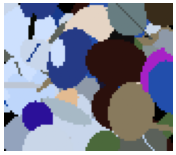

Generation:  11 . Fitness:  -1211.8738


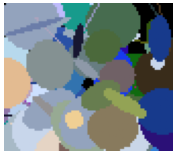

Generation:  21 . Fitness:  -1032.78


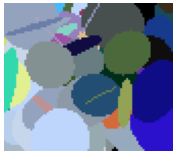

Generation:  31 . Fitness:  -932.0639


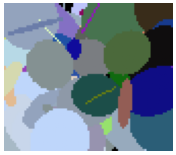

Generation:  41 . Fitness:  -849.15125


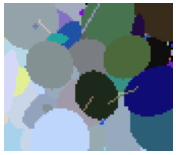

Generation:  51 . Fitness:  -803.7651


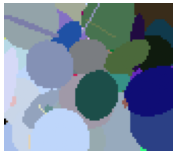

Generation:  61 . Fitness:  -773.36993


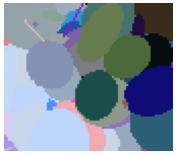

Generation:  71 . Fitness:  -745.46484


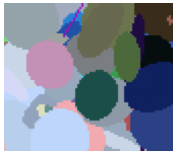

Generation:  81 . Fitness:  -718.9851


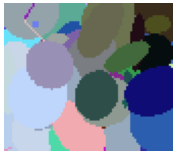

Generation:  91 . Fitness:  -689.1396


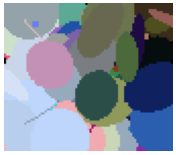

Generation:  101 . Fitness:  -668.16724


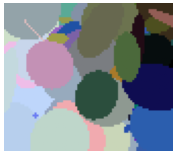

Generation:  111 . Fitness:  -655.01056


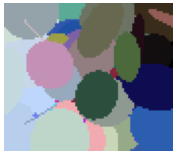

Generation:  121 . Fitness:  -651.9999


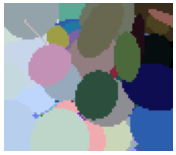

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


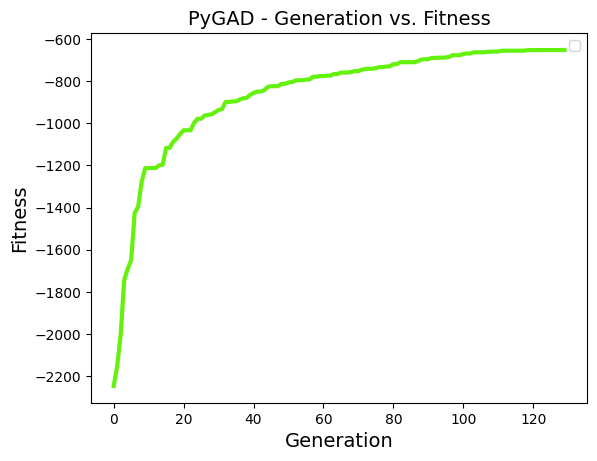

Parameters of the best solution : [2.35294122e-02 3.13725509e-02 3.92156886e-03 1.75172706e-01
 8.95146611e-02 5.46751956e-01 7.97484708e-01 2.77375039e-01
 5.90187206e-01 8.78431380e-01 1.34279045e-01 6.40130997e-01
 6.84372913e-01 4.54318651e-01 3.35495243e-01 5.96972890e-01
 6.01339689e-01 3.80392164e-01 8.37236138e-01 4.52932971e-01
 5.18768177e-01 6.41369611e-02 9.43880481e-01 1.28745621e-01
 2.94117659e-01 5.45008196e-01 7.36631385e-01 7.82384008e-01
 5.90078059e-01 4.47642588e-01 7.91894822e-01 1.33737351e-01
 9.17394670e-01 2.27450982e-01 5.25490224e-01 3.95346482e-01
 6.54954056e-01 4.46560225e-01 1.49005641e-01 4.17769953e-01
 8.25600264e-01 4.31372561e-02 4.16441180e-01 1.72192097e-01
 2.15452835e-01 9.76549727e-02 7.08052631e-01 9.83450863e-02
 5.92156887e-01 7.36332550e-01 4.19354023e-01 2.07136313e-01
 4.68476559e-01 9.29189715e-01 5.33005901e-01 1.98848002e-01
 7.56219873e-02 5.68627477e-01 5.72549045e-01 8.86830452e-02
 2.76811731e-01 9.73450632e-01 1.88357223e-01 2.721

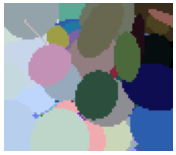

Step:  1
Generation:  1 . Fitness:  -1481.9199


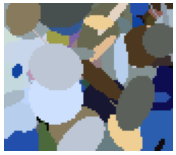

Generation:  11 . Fitness:  -851.71173


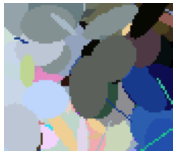

Generation:  21 . Fitness:  -720.3528


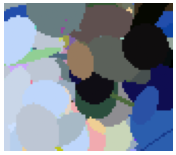

Generation:  31 . Fitness:  -660.7601


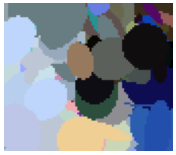

Generation:  41 . Fitness:  -608.65076


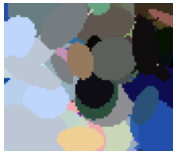

Generation:  51 . Fitness:  -581.98676


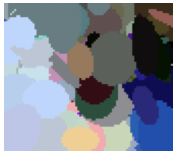

Generation:  61 . Fitness:  -566.4754


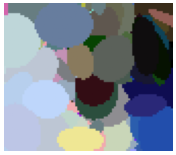

Generation:  71 . Fitness:  -552.73645


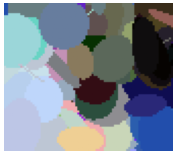

Generation:  81 . Fitness:  -546.02783


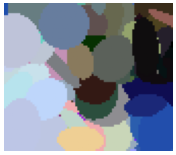

Generation:  91 . Fitness:  -537.0683


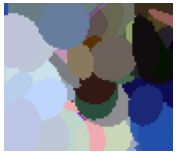

Generation:  101 . Fitness:  -529.6029


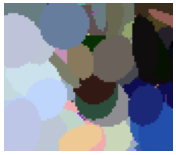

Generation:  111 . Fitness:  -524.5267


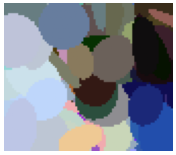

Generation:  121 . Fitness:  -516.99243


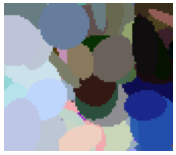

Generation:  131 . Fitness:  -514.06494


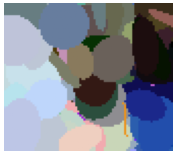

Generation:  141 . Fitness:  -513.64734


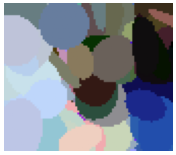

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


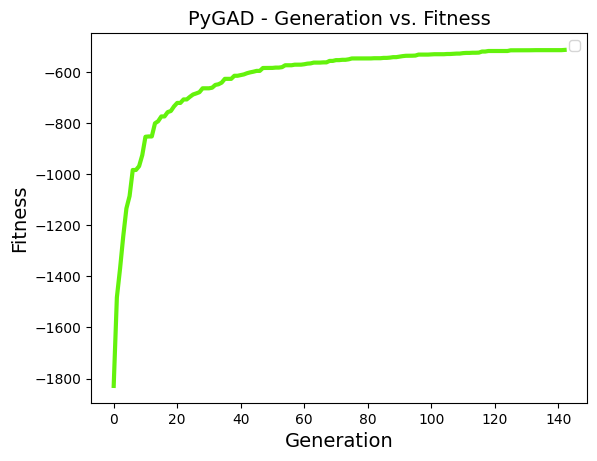

Parameters of the best solution : [6.82023529e-01 4.11884663e-01 4.95517077e-01 5.03349513e-01
 5.77075596e-01 2.76452081e-01 6.62495344e-01 2.78394039e-01
 5.49019612e-02 2.62745112e-01 6.64799775e-01 2.07618073e-01
 4.61948100e-01 3.97315265e-01 2.41125134e-01 3.97272311e-01
 3.01960796e-01 9.16723549e-01 3.13527482e-01 9.46389428e-01
 9.36291753e-01 8.47482176e-02 1.72968443e-01 2.97925207e-01
 8.42400086e-01 3.46837068e-01 7.68627465e-01 2.27776736e-01
 6.96407507e-02 1.52983160e-01 2.50263024e-01 5.40900606e-01
 6.38800481e-01 8.78431380e-01 4.73643365e-02 1.33379310e-01
 3.76101258e-01 7.49422861e-01 1.90770159e-01 8.15235871e-02
 7.49496561e-01 9.01960805e-02 9.29411769e-01 1.52348744e-01
 8.15504354e-01 4.47060048e-01 9.20401524e-01 3.54940937e-01
 7.24243535e-01 6.23029825e-01 3.68340061e-01 1.84659854e-01
 9.25294726e-01 8.57611993e-01 8.94170783e-01 6.48642708e-01
 8.84434049e-01 5.05393730e-01 4.51460996e-01 5.68150845e-01
 4.87830037e-01 3.58405512e-01 1.80366467e-01 3.364

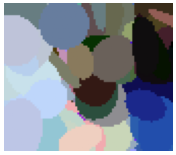

Step:  2
Generation:  1 . Fitness:  -784.1915


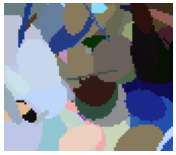

Generation:  11 . Fitness:  -520.7308


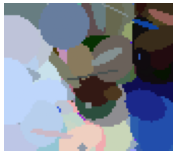

Generation:  21 . Fitness:  -490.15277


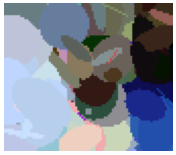

Generation:  31 . Fitness:  -473.11395


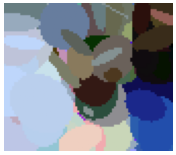

Generation:  41 . Fitness:  -463.909


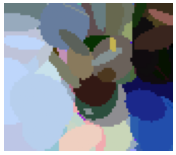

Generation:  51 . Fitness:  -449.5604


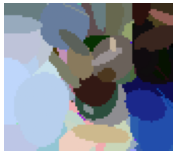

Generation:  61 . Fitness:  -440.88858


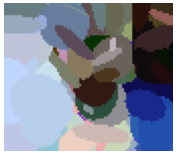

Generation:  71 . Fitness:  -433.9487


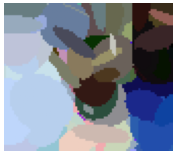

Generation:  81 . Fitness:  -428.91217


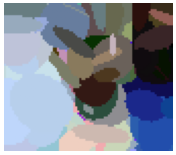

Generation:  91 . Fitness:  -425.97067


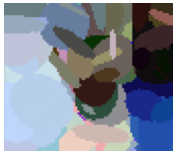

Generation:  101 . Fitness:  -424.44797


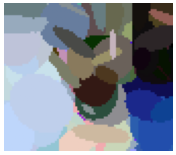

Generation:  111 . Fitness:  -422.0991


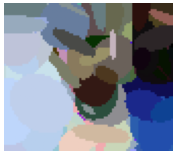

Generation:  121 . Fitness:  -419.33536


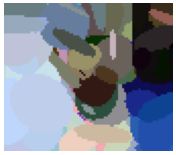

Generation:  131 . Fitness:  -417.2738


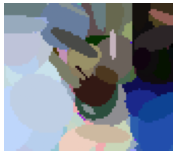

Generation:  141 . Fitness:  -415.98434


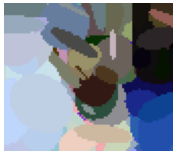

Generation:  151 . Fitness:  -413.67157


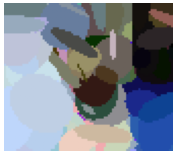

Generation:  161 . Fitness:  -413.2906


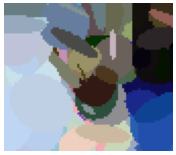

Generation:  171 . Fitness:  -410.6948


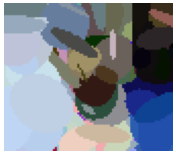

Generation:  181 . Fitness:  -407.65054


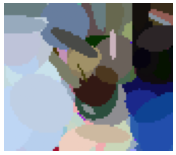

Generation:  191 . Fitness:  -406.2007


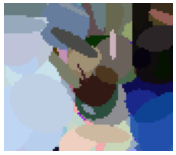

Generation:  201 . Fitness:  -403.83655


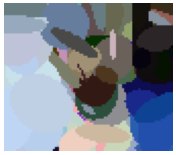

Generation:  211 . Fitness:  -403.30377


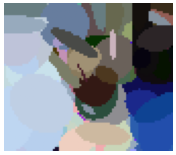

Generation:  221 . Fitness:  -401.3304


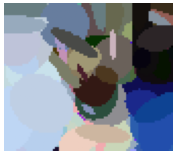

Generation:  231 . Fitness:  -398.80823


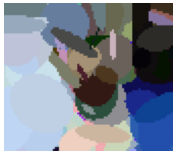

Generation:  241 . Fitness:  -396.59497


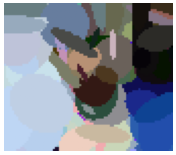

Generation:  251 . Fitness:  -393.78302


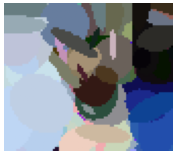

Generation:  261 . Fitness:  -391.362


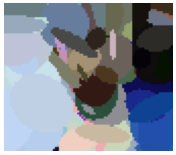

Generation:  271 . Fitness:  -390.10748


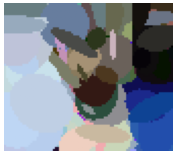

Generation:  281 . Fitness:  -388.49097


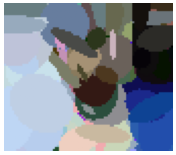

Generation:  291 . Fitness:  -386.58948


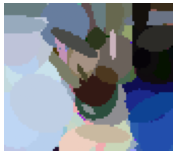

Generation:  301 . Fitness:  -385.5653


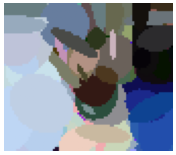

Generation:  311 . Fitness:  -384.64307


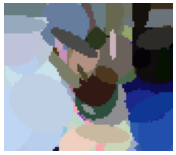

Generation:  321 . Fitness:  -383.82755


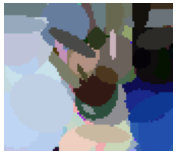

Generation:  331 . Fitness:  -383.00687


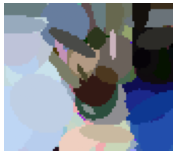

Generation:  341 . Fitness:  -382.30585


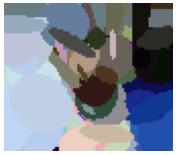

Generation:  351 . Fitness:  -381.7266


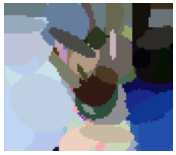

Generation:  361 . Fitness:  -381.28354


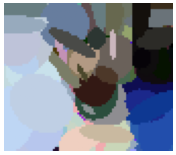

Generation:  371 . Fitness:  -380.9741


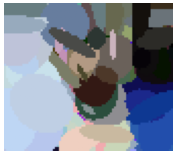

Generation:  381 . Fitness:  -380.9326


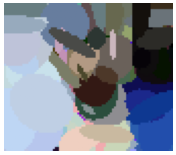

Generation:  391 . Fitness:  -379.95657


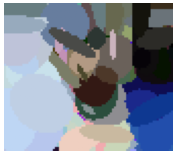

Generation:  401 . Fitness:  -379.0921


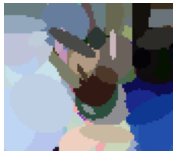

Generation:  411 . Fitness:  -377.85922


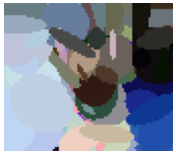

Generation:  421 . Fitness:  -376.72287


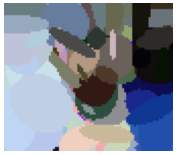

Generation:  431 . Fitness:  -376.32166


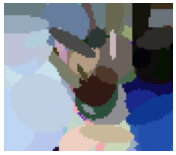

Generation:  441 . Fitness:  -375.72427


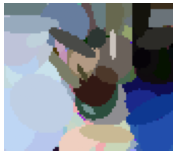

Generation:  451 . Fitness:  -375.02


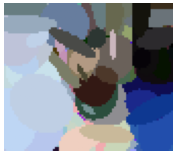

Generation:  461 . Fitness:  -374.0174


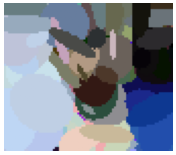

Generation:  471 . Fitness:  -373.76172


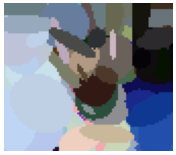

Generation:  481 . Fitness:  -373.62344


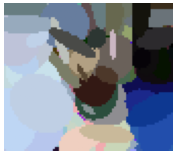

Generation:  491 . Fitness:  -373.43445


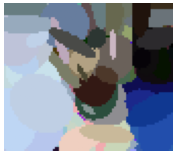

Generation:  501 . Fitness:  -372.57175


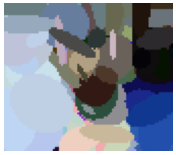

Generation:  511 . Fitness:  -372.28802


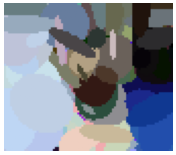

Generation:  521 . Fitness:  -372.04587


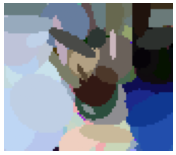

Generation:  531 . Fitness:  -371.94272


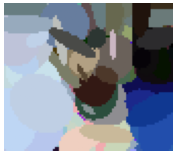

Generation:  541 . Fitness:  -371.46255


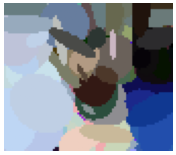

Generation:  551 . Fitness:  -371.32675


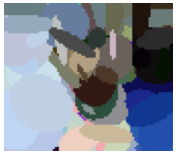

Generation:  561 . Fitness:  -371.08322


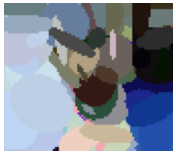

Generation:  571 . Fitness:  -371.0493


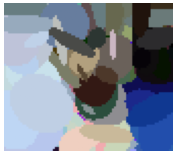

Generation:  581 . Fitness:  -370.99942


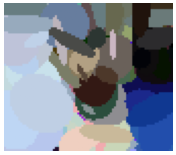

Generation:  591 . Fitness:  -370.95462


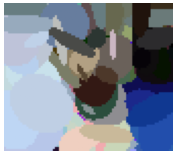

Generation:  601 . Fitness:  -370.74756


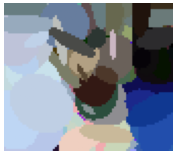

Generation:  611 . Fitness:  -370.5234


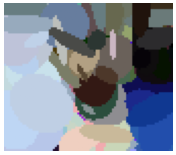

Generation:  621 . Fitness:  -370.25027


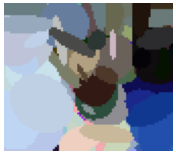

Generation:  631 . Fitness:  -370.207


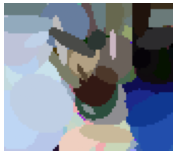

Generation:  641 . Fitness:  -370.1357


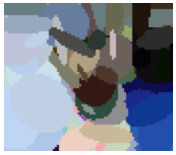

Generation:  651 . Fitness:  -370.09006


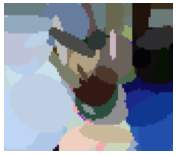

Generation:  661 . Fitness:  -369.99228


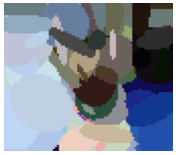

Generation:  671 . Fitness:  -369.95035


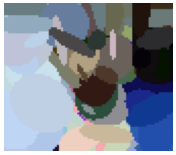

Generation:  681 . Fitness:  -369.77585


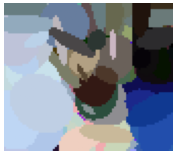

Generation:  691 . Fitness:  -369.77585


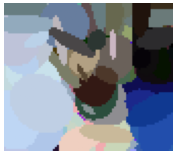

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


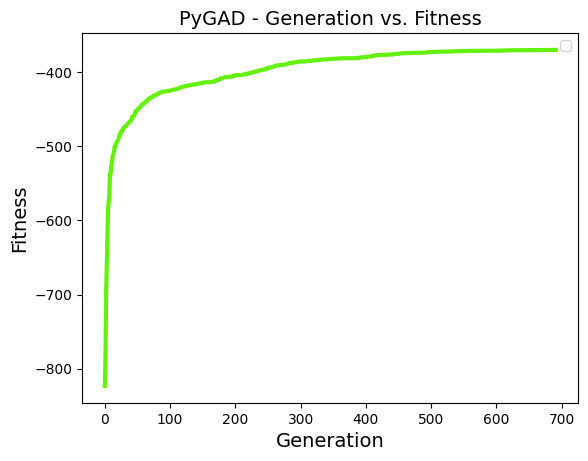

Parameters of the best solution : [6.32309203e-02 2.25834823e-01 5.69366790e-01 8.86932071e-01
 7.21459962e-01 4.02046852e-01 9.63802679e-01 1.79484124e-01
 4.17418413e-01 4.79584592e-01 4.75228944e-01 8.99958187e-01
 1.01137085e-01 9.21873493e-01 2.87833455e-01 9.83313805e-01
 6.99789002e-01 6.27796496e-01 5.13970726e-01 4.70612496e-01
 3.69996221e-01 3.87101351e-01 5.77068896e-01 1.07423317e-01
 3.46965935e-01 2.78607512e-01 1.97921403e-01 4.58442886e-01
 4.77504472e-01 1.00178649e-01 3.10460376e-01 9.27465931e-01
 7.99283550e-01 7.16659277e-01 7.62203594e-01 6.48392646e-01
 2.81140753e-01 4.47173171e-01 8.95107620e-02 7.44630712e-01
 1.73442418e-01 1.69950471e-01 1.76858256e-01 9.04622102e-01
 2.35821962e-01 3.34841566e-01 7.12506480e-01 7.10843831e-01
 3.01960796e-01 2.19607845e-01 1.67454689e-01 6.11369442e-01
 4.86120617e-01 2.01847586e-01 4.34613549e-01 8.34382702e-01
 7.30893948e-01 8.19733891e-01 9.12703236e-01 1.97128015e-01
 2.46451144e-01 4.65887489e-01 2.06849801e-01 9.189

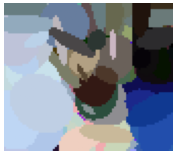

In [181]:
%matplotlib inline

solution_images = []

# Loop over painting layers
for step in range(N_STEP):
    n_shapes = N_SHAPES_LIST[step]
    n_individual = N_INDIVIDUAL_LIST[step]
    transparency = TRANSPARENCY_LIST[step]

    # Generate an initial population
    initial_population = [generate_random_chromosomes(n_shapes) for i in np.arange(n_individual)]

    # Use a black canvas if this is the first painting layer
    # otherwise use the previous best image as canvas
    if step == 0:
        canvas = np.full_like(original_image, fill_value=0)
    else:
        canvas = best_solution_image.copy()

    print("Step: ", step)

    # Define min and max values for each genes
    gene_space = [
        {'low': 0, 'high': 1}
    ] * N_PROPERTIES * n_shapes

    # Create a new genetic algorithm instance
    ga_instance = pygad.GA(
        num_generations=1000,
        num_parents_mating=round(0.2 * len(initial_population)),
        fitness_func=fitness_function(canvas, transparency),
        initial_population=initial_population,
        gene_type=float,
        gene_space=gene_space,
        on_generation=on_gen(canvas, transparency),
        random_mutation_min_val=-0.15,
        random_mutation_max_val=0.15,
        mutation_type="adaptive",
        mutation_probability=[0.03, 0.01],
        crossover_type="two_points",
        crossover_probability=0.8,
        parent_selection_type="sss",
        stop_criteria="saturate_10",
    )

    # Run genetic algorithm
    ga_instance.run()

    # Save checkpoint
    ga_instance.save(f"GA_checkpoint_{step + 1}")

    # Plot fitness
    ga_instance.plot_fitness()

    # Print best solution results
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

    best_solution_image = draw_individual(solution, canvas=canvas, transparency=transparency)
    solution_images.append(best_solution_image)

    # Plot best solution painting
    plt.figure(dpi=40)
    plt.imshow(best_solution_image, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()


## <font color="brown">🕵️&nbsp;&nbsp; Display Evolution's Animation</font>

In [182]:
%matplotlib notebook

# Define the function to animate the plot
def animate(i):
    # Clear the axis
    ax.clear()

    # Plot the data
    ax.imshow(solution_images[i], vmin=0, vmax=255)
    plt.axis('Off')
    plt.show()

In [183]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create a figure and axis object
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, animate, frames=len(solution_images), interval=100)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

RuntimeError: Requested MovieWriter (ffmpeg) not available

## <font color="brown">🎯&nbsp;&nbsp; Your task</font>

Your task is to change this implementation in the following way:

- Instead of using polygons with 4 corners the shape must be ellipses.
- Restrict the colors to a palette of colors (For instance of 32 colors) taken from the original image.
- We don't want transparency anymore.
- Change the image to an image of your choice (please make sure the image size is not too big).

Tips:

- Make sure the lowest value for the lengths is not 0. Otherwise the genetic algorithm could learn to generate "empty" shapes instead of optimizing them. You may also want to generate small shapes by default and let the GA learn to increase their size.
- The easiest way is to generate values between 0 and 1 and then to convert them to the correct ranges for each values (e.g. the image width and height for the position)

_If the training time is a problem, try with fewer shapes, layers and generations. Furthemore, changing some of the GA parameters will help the model converge faster but can sometimes make it more difficult to have good results._

## <font color="brown">🌠&nbsp;&nbsp;Example of result</font>

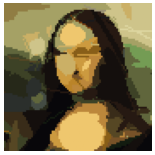

## <font color="brown">📖&nbsp;&nbsp; Report</font>

Please submit in your report:

1. The way you extracted the color palette
2. Your parameters N_SHAPES_LIST, N_INDIVIDUAL_LIST
3. Your parameters to train the genetic algorithm
4. How you define the chromosomes (what are the genes you defined and what they represent)
5. Initial image you choosed and the resulting image you obtained
6. Fitness plots

**Submit your notebook as well**

#### 1.

To extract the color palette, we simply selected all RGB pixels value in the given image, we filtered duplicates and finally, we picked randomly 32 colors from the filtered list.

```python
pixel_values = original_image.reshape(-1, 3)
PALETTE = np.unique(pixel_values, axis=0) # Get unique colors in the image
random_palette_idx = np.random.choice(len(PALETTE), 32, replace=False) # Choose 32 random colors from the palette
PALETTE = PALETTE[random_palette_idx]
```

#### 2.

We kept the same values for the parameters as the original code. Adding too much shapes made the result more detailed for the background but the face of the dog became less detailed as a result.

N_SHAPES_LIST = [120, 60, 20]
N_INDIVIDUAL_LIST = [250, 500, 500]

#### 3.

We kept the one from the original code and can be seen above.

#### 4.

With asked modifications, chromosome now have this structure: 

\[Red, Green, Blue, ellipse center X, ellipse center Y, ellipse width, ellipse height, ellipse angle\]

each gene is normalized to be in the range \[0, 1\].

#### 5.

source image:

![chien_lesser_res.jpg](./img/chien_lesser_res.jpg)

result: 

![result.png](./img/result.png)